In [1]:
import numpy as np
import pandas as pd

In [2]:
np.random.seed(42)

## Utils

In [3]:
def split_dataset(df, val_ratio, test_ratio):
    df_index_shuffled = df.reset_index()['index'].values
    np.random.shuffle(df_index_shuffled)
    
    n = len(df)
    n_val = int(n * val_ratio)
    n_test = int(n * test_ratio)
    n_train = n - n_val - n_test

    train_idx = df_index_shuffled[:n_train]
    val_idx = df_index_shuffled[n_train:n_train+n_val]
    test_idx = df_index_shuffled[n_train+n_val:]
    
    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[test_idx].reset_index(drop=True)
    test_df = df.iloc[val_idx].reset_index(drop=True)
    return train_df, val_df, test_df


def train_linear_regression(X, y, alpha=0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_regularized = XTX + (alpha * np.eye(XTX.shape[0]))
    XTX_inv = np.linalg.inv(XTX_regularized)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w


def rmse(y_pred, y_actual):
    return float(np.sqrt(np.mean((y_pred - y_actual) ** 2)))


def evaluate_model(w, X_val, y_val):
    ones = np.ones(X_val.shape[0])
    X_val = np.column_stack([ones, X_val])
    y_pred = w.dot(X_val.T)

    score = rmse(y_pred, y_val)
    return score

def impute_by_mean(df, train_df, missing_col_name):
    to_impute_df = df.copy()
    mean_missing_col = np.mean(train_df[missing_col_name])
    to_impute_df[missing_col_name] = to_impute_df[missing_col_name].fillna(mean_missing_col)
    return to_impute_df

def impute_by_zeros(df, missing_col_name):
    to_impute_df = df.copy()
    to_impute_df[missing_col_name] = to_impute_df[missing_col_name].fillna(0)
    return to_impute_df

## Data Acquisition

In [4]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

--2025-10-08 22:44:33--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv.4’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.02s   

2025-10-08 22:44:33 (44.0 MB/s) - ‘car_fuel_efficiency.csv.4’ saved [874188/874188]



In [5]:
raw_df = pd.read_csv('car_fuel_efficiency.csv')

## EDA

In [6]:
df = raw_df[
    ['engine_displacement', 'horsepower', 'vehicle_weight', 
     'model_year', 'fuel_efficiency_mpg']
]

<Axes: >

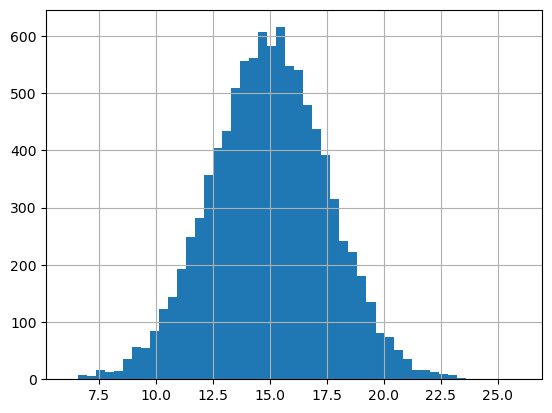

In [7]:
df.fuel_efficiency_mpg.hist(bins=50)

## Question 1

In [8]:
missing_col_name = df.columns[df.isnull().sum() > 0][0]
print(f"Answer to Q1 is: {missing_col_name}")

Answer to Q1 is: horsepower


## Question 2

In [9]:
print(f"Answer to Q2 is: {df.horsepower.median():.0f}")

Answer to Q2 is: 149


## Prepare and split the dataset

In [10]:
train_df, val_df, test_df = split_dataset(df, 0.2, 0.2)

In [11]:
train_df.shape[0] + val_df.shape[0] + test_df.shape[0] == df.shape[0]

True

## Question 3

In [12]:
y_train = train_df.fuel_efficiency_mpg.values
X_train = train_df.drop('fuel_efficiency_mpg', axis=1)
X_train_mean_imp = impute_by_mean(df=train_df, train_df=train_df, missing_col_name=missing_col_name).values
X_train_zeros_imp = impute_by_zeros(train_df, missing_col_name=missing_col_name).values

In [13]:
y_val = val_df.fuel_efficiency_mpg.values
X_val = val_df.drop('fuel_efficiency_mpg', axis=1)
X_val_mean_imp = impute_by_mean(df=val_df, train_df=train_df, missing_col_name=missing_col_name).values
X_val_zeros_imp = impute_by_zeros(val_df, missing_col_name=missing_col_name).values

In [14]:
X_val_zeros_imp.shape

(1940, 5)

In [15]:
w_mean_imp = train_linear_regression(X_train_mean_imp, y_train)
w_zeros_imp = train_linear_regression(X_train_zeros_imp, y_train)

In [16]:
mean_imp_score = round(evaluate_model(w_mean_imp, X_val_mean_imp, y_val), 2)
zeros_imp_score = round(evaluate_model(w_zeros_imp, X_val_zeros_imp, y_val), 2)

In [18]:
print("Answer to Q3 is: With mean")


Answer to Q3 is: With mean


## Question 4

In [17]:
alphas = [0, 0.01, 0.1, 1, 5, 10, 100]
scores = np.zeros(len(alphas))

for i, alpha in enumerate(alphas):
    w = train_linear_regression(X_train_zeros_imp, y_train, alpha=alpha)
    score = round(evaluate_model(w, X_val_zeros_imp, y_val), 2)
    scores[i] = score

min_score = np.min(np.where(scores == scores.min()))
print(f"Answer to Q4 is: {min_score}")

Answer to Q4 is: 0


# Question 5

In [18]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = np.zeros(len(seeds))

for i, seed in enumerate(seeds):
    np.random.seed(seed)
    train_df, val_df, test_df = split_dataset(df, 0.2, 0.2)
    
    y_train = train_df.fuel_efficiency_mpg.values
    X_train_zeros_imp = prepare_X(train_df, imputation_method='zeros', missing_col_name=missing_col_name)
    w_zeros_imp = train_linear_regression(X_train_zeros_imp, y_train)
    
    X_val_zeros_imp = prepare_X(val_df, imputation_method='zeros', missing_col_name=missing_col_name)
    y_val = val_df.fuel_efficiency_mpg.values
    
    score = evaluate_model(w_zeros_imp, X_val_zeros_imp, y_val)
    scores[i] = score

print(f"Answer to Q5 is: {round(np.std(scores), 3)}")

Answer to Q5 is: 0.008


## Question 6

In [19]:
np.random.seed(9)
train_df, val_df, test_df = split_dataset(df, 0.2, 0.2)
full_train_df = pd.concat([train_df, val_df], ignore_index=True)

y_train = full_train_df.fuel_efficiency_mpg.values
X_train_zeros_imp = prepare_X(full_train_df, imputation_method='zeros', missing_col_name=missing_col_name)
w_zeros_imp = train_linear_regression(X_train_zeros_imp, y_train, alpha=0.001)

X_test_zeros_imp = prepare_X(test_df, imputation_method='zeros', missing_col_name=missing_col_name)
y_test = test_df.fuel_efficiency_mpg.values

score = evaluate_model(w_zeros_imp, X_test_zeros_imp, y_test)
print(f"Answer to Q6 is: {round(score, 3)}")

Answer to Q6 is: 0.513
